In [ ]:
import pandas as pd

# Load dataset
file_path = "/content/drive/MyDrive/Labmentex/Uber/final Dataset.csv"
df = pd.read_csv(file_path)
print("📦 Original dataset shape:", df.shape)


📦 Original dataset shape: (6745, 6)


In [ ]:
# Step 1: Strip extra spaces & unify delimiters in timestamps
df['Request timestamp'] = df['Request timestamp'].astype(str).str.replace('-', '/').str.strip()
df['Drop timestamp'] = df['Drop timestamp'].astype(str).str.replace('-', '/').str.strip()

# Step 2: Convert to datetime safely
df['Request timestamp'] = pd.to_datetime(df['Request timestamp'], dayfirst=True, errors='coerce')
df['Drop timestamp'] = pd.to_datetime(df['Drop timestamp'], dayfirst=True, errors='coerce')

# Step 3: Debug nulls after conversion
print("\n⚠️ Nulls after datetime conversion:")
print(df[['Request timestamp', 'Drop timestamp']].isna().sum())


⚠️ Nulls after datetime conversion:
Request timestamp       0
Drop timestamp       3914
dtype: int64


In [ ]:
# Step 4: Fix overnight trips (drop time before request time)
mask1 = (
    (df['Status'] == 'Trip Completed') &
    df['Drop timestamp'].notna() &
    df['Request timestamp'].notna() &
    (df['Drop timestamp'] < df['Request timestamp'])
)
df.loc[mask1, 'Drop timestamp'] += pd.Timedelta(days=1)

In [ ]:
# Step 5: Fix wrong-month errors (like Dec interpreted as July)
mask2 = (
    (df['Status'] == 'Trip Completed') &
    df['Drop timestamp'].notna() &
    df['Request timestamp'].notna() &
    ((df['Drop timestamp'] - df['Request timestamp']).dt.total_seconds().between(86400, 2678400)) &
    (df['Drop timestamp'].dt.month != df['Request timestamp'].dt.month)
)
df.loc[mask2, 'Drop timestamp'] -= pd.DateOffset(months=1)
df.loc[mask2, 'Drop timestamp'] += pd.Timedelta(days=1)

In [ ]:

# Step 6: Calculate trip duration
df['Trip Duration (min)'] = (
    df['Drop timestamp'] - df['Request timestamp']
).dt.total_seconds() / 60


In [ ]:

# Step 7: Flag valid durations
df['Is Valid Duration'] = (
    (df['Trip Duration (min)'] > 0) &
    (df['Trip Duration (min)'] < 1400)
)

In [ ]:

# Step 8: Add time-based columns
df['Request Hour'] = df['Request timestamp'].dt.hour
df['Request Day'] = df['Request timestamp'].dt.date
df['Request Weekday'] = df['Request timestamp'].dt.day_name()
df['Weekday'] = df['Request timestamp'].dt.day_name()  # duplicate if needed for specific plotting


In [ ]:
# Step 9: Select final columns
final_columns = [
    'Request id', 'Pickup point', 'Driver id', 'Status',
    'Request timestamp', 'Drop timestamp', 'Trip Duration (min)',
    'Is Valid Duration', 'Request Hour', 'Request Day',
    'Request Weekday', 'Weekday'
]
df_final = df[final_columns]

In [ ]:
# Step 11: Summary stats
print("\n✅ Final dataset shape (no rows dropped):", df_final.shape)
valid_trips = df_final.query("Status == 'Trip Completed' and `Is Valid Duration`").shape[0]
invalid_trips = df_final.query("Status == 'Trip Completed' and not `Is Valid Duration`").shape[0]

print("🟢 Valid Trip Completed rows with good durations:", valid_trips)
print("🔴 Invalid Trip Completed rows (duration missing or bad):", invalid_trips)
df_filtered.to_csv("Cleaned_data.csv", index=False)



✅ Final dataset shape (no rows dropped): (6745, 12)
🟢 Valid Trip Completed rows with good durations: 2818
🔴 Invalid Trip Completed rows (duration missing or bad): 13


📊 1. Hourly Total Requests


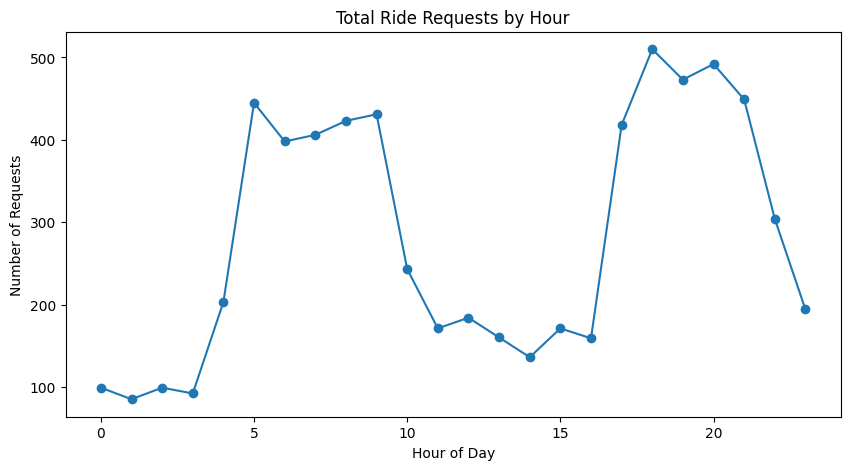

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
df['Request Hour'].value_counts().sort_index().plot(marker='o')
plt.title("Total Ride Requests by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Requests")
plt.show()
# Insight: Identifies peak ride demand hours.


In [ ]:
# Group data by hour
hourly_status = df_filtered.groupby(['Request Hour', 'Status']).size().unstack(fill_value=0)

# Create each series from the table
total_requests = hourly_status.sum(axis=1)
completed_requests = hourly_status.get('Trip Completed', pd.Series(0, index=total_requests.index))
cancelled_requests = hourly_status.get('Cancelled', pd.Series(0, index=total_requests.index))
no_cars_requests = hourly_status.get('No Cars Available', pd.Series(0, index=total_requests.index))


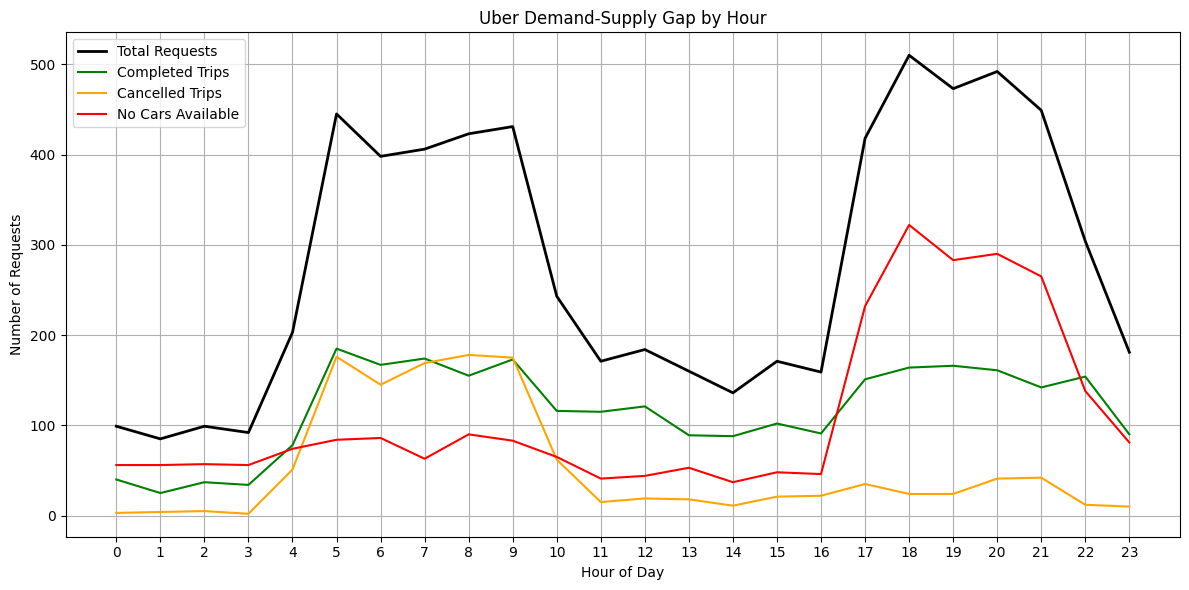

In [ ]:

plt.figure(figsize=(12, 6))
plt.plot(total_requests, label='Total Requests', color='black', linewidth=2)
plt.plot(completed_requests, label='Completed Trips', color='green')
plt.plot(cancelled_requests, label='Cancelled Trips', color='orange')
plt.plot(no_cars_requests, label='No Cars Available', color='red')

plt.title("Uber Demand-Supply Gap by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Requests")
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


In [ ]:
demand_gap = pd.DataFrame({
    'Total': total_requests,
    'Completed': completed_requests,
    'Cancelled': cancelled_requests,
    'No Cars': no_cars_requests
}).fillna(0)

demand_gap['Unfulfilled %'] = ((demand_gap['Cancelled'] + demand_gap['No Cars']) / demand_gap['Total']) * 100


In [ ]:
demand_gap['Unfulfilled %']

,Unfulfilled %
Request Hour,
0,59.595960
1,70.588235
2,62.626263
3,63.043478
4,61.576355
5,58.426966
6,58.040201
7,57.142857
8,63.356974


✅ Step 8: Trip Duration Analysis


✅ Step 8A: Descriptive Stats on Trip Duration


In [ ]:
# Analyze only completed, cleaned trips
completed_trips = df_filtered.query("Status == 'Trip Completed' and `Is Valid Duration`")
duration_stats = completed_trips['Trip Duration (min)'].describe()
print(duration_stats)

count    2818.000000
mean       52.410575
std        13.845550
min        20.783333
25%        41.000000
50%        52.091667
75%        64.000000
max        83.000000
Name: Trip Duration (min), dtype: float64


✅ Step 8B: Plot Trip Duration Distribution


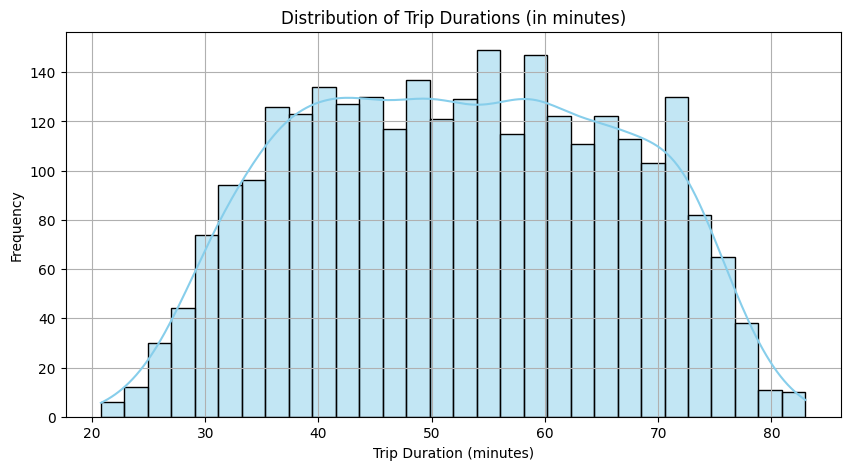

In [ ]:

plt.figure(figsize=(10, 5))
sns.histplot(completed_trips['Trip Duration (min)'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Trip Durations (in minutes)")
plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


📊 2. Hourly Completed Trips

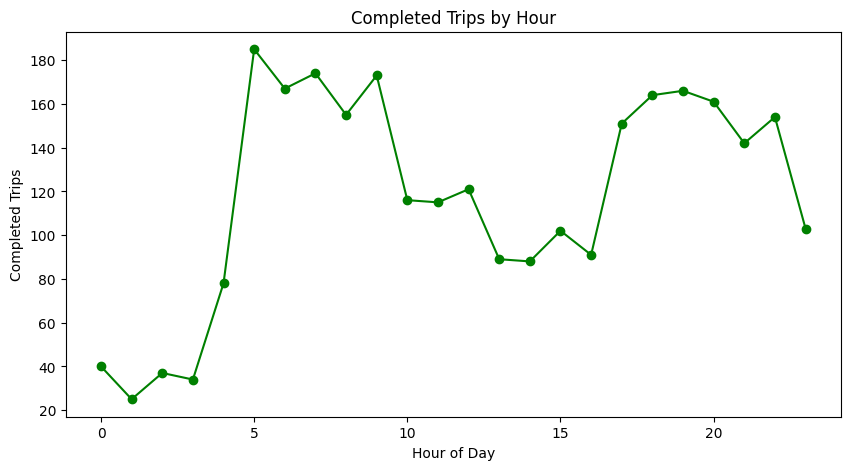

In [ ]:
plt.figure(figsize=(10, 5))
df[df['Status'] == 'Trip Completed']['Request Hour'].value_counts().sort_index().plot(marker='o', color='green')
plt.title("Completed Trips by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Completed Trips")
plt.show()
# Insight: Shows actual supply fulfillment by hour.


✅ Step 9: Driver Performance Analysis

In [ ]:
# Count completed trips per driver
driver_trip_counts = completed_trips['Driver id'].value_counts().sort_values(ascending=False)

# Preview top 10
print(driver_trip_counts.head(10))

Driver id
22.0     16
184.0    15
233.0    15
126.0    14
134.0    14
70.0     14
107.0    14
105.0    14
176.0    14
23.0     14
Name: count, dtype: int64


Step 9B: Number of Cancellations by Driver

In [ ]:
# Filter for cancelled trips
cancelled = df_filtered[df_filtered['Status'] == 'Cancelled']

# Only look at rows where a driver was assigned but trip was cancelled
cancelled_with_driver = cancelled[cancelled['Driver id'].notnull()]

# Count cancellations per driver
driver_cancellation_counts = cancelled_with_driver['Driver id'].value_counts().sort_values(ascending=False)

# Preview top 10
print(driver_cancellation_counts.head(10))


Driver id
84.0     12
54.0     11
206.0    10
142.0    10
27.0      9
138.0     9
114.0     9
210.0     9
267.0     9
166.0     9
Name: count, dtype: int64


In [ ]:
# Combine both into a DataFrame
driver_summary = pd.DataFrame({
    'Completed': driver_trip_counts,
    'Cancelled': driver_cancellation_counts
}).fillna(0)

driver_summary['Total Assigned'] = driver_summary['Completed'] + driver_summary['Cancelled']
driver_summary['Cancellation Rate (%)'] = (driver_summary['Cancelled'] / driver_summary['Total Assigned']) * 100

# Preview
print(driver_summary.sort_values(by='Cancellation Rate (%)', ascending=False).head(10))


           Completed  Cancelled  Total Assigned  Cancellation Rate (%)
Driver id                                                             
267.0              6        9.0            15.0              60.000000
206.0              7       10.0            17.0              58.823529
104.0              5        7.0            12.0              58.333333
103.0              5        7.0            12.0              58.333333
54.0               8       11.0            19.0              57.894737
131.0              6        8.0            14.0              57.142857
84.0               9       12.0            21.0              57.142857
210.0              7        9.0            16.0              56.250000
135.0              5        6.0            11.0              54.545455
229.0              6        7.0            13.0              53.846154


Top 10 Driver by Cancellation

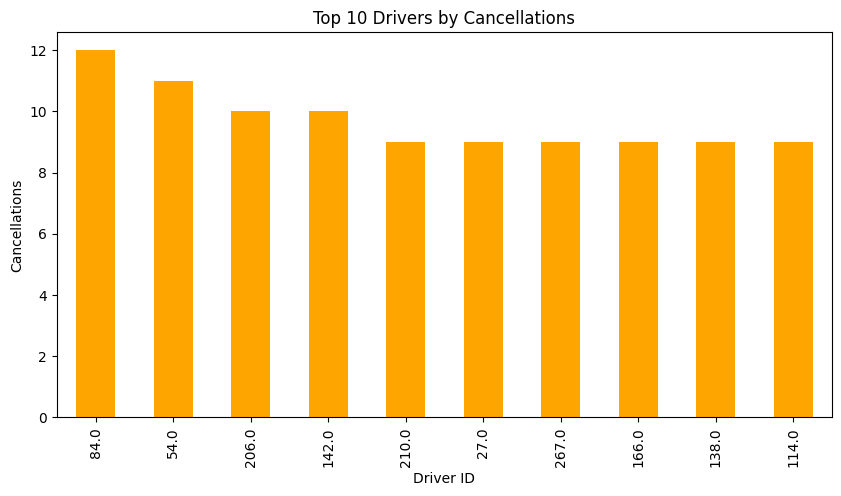

In [ ]:
import matplotlib.pyplot as plt

# Filter only cancelled trips where Driver id is known
df_cancelled = df[(df['Status'] == 'Cancelled') & (df['Driver id'].notna())]

# Check if there's anything to plot
driver_cancel_counts = df_cancelled['Driver id'].value_counts().head(10)

if not driver_cancel_counts.empty:
    plt.figure(figsize=(10, 5))
    driver_cancel_counts.plot(kind='bar', color='orange')
    plt.title("Top 10 Drivers by Cancellations")
    plt.xlabel("Driver ID")
    plt.ylabel("Cancellations")
    plt.show()
else:
    print("⚠️ No valid 'Cancelled' records with Driver IDs available to plot.")


4) No Cars Available by Hour (Line Plot)

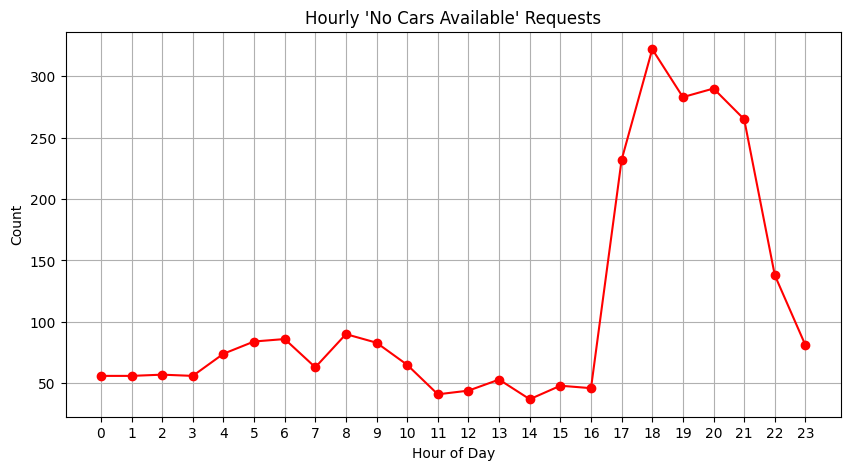

In [ ]:
hourly_no_cars = df[df['Status'] == 'No Cars Available'].groupby(df['Request timestamp'].dt.hour)['Request id'].count()

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
hourly_no_cars.plot(marker='o', color='red')
plt.title("Hourly 'No Cars Available' Requests")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.grid(True)
plt.xticks(range(0,24))
plt.show()


5) Trip Duration Distribution (Histogram)

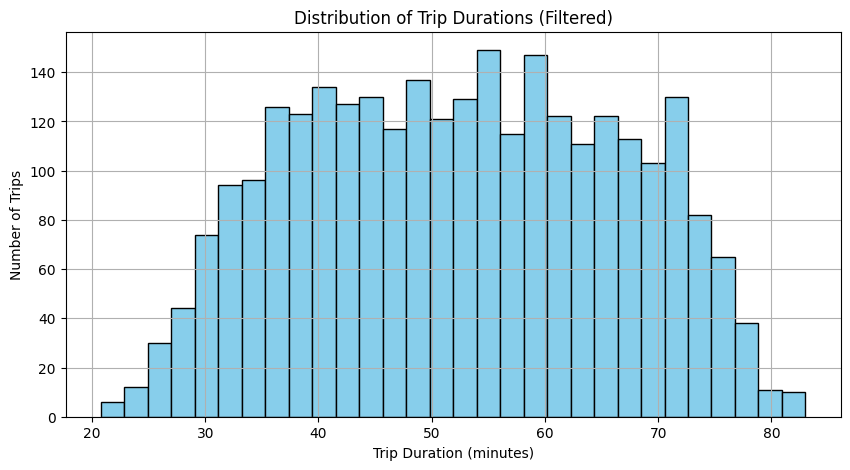

In [ ]:
# Define reasonable trip duration range (e.g., 0–300 mins)
valid_trips = df[(df['Status'] == 'Trip Completed') &
                 (df['Trip Duration (min)'] > 0) &
                 (df['Trip Duration (min)'] < 300)]

trip_duration = valid_trips['Trip Duration (min)']

# Plot after filtering
plt.figure(figsize=(10,5))
plt.hist(trip_duration, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Trip Durations (Filtered)")
plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Number of Trips")
plt.grid(True)
plt.show()


7) Hourly Status Share (Stacked Bar Chart)


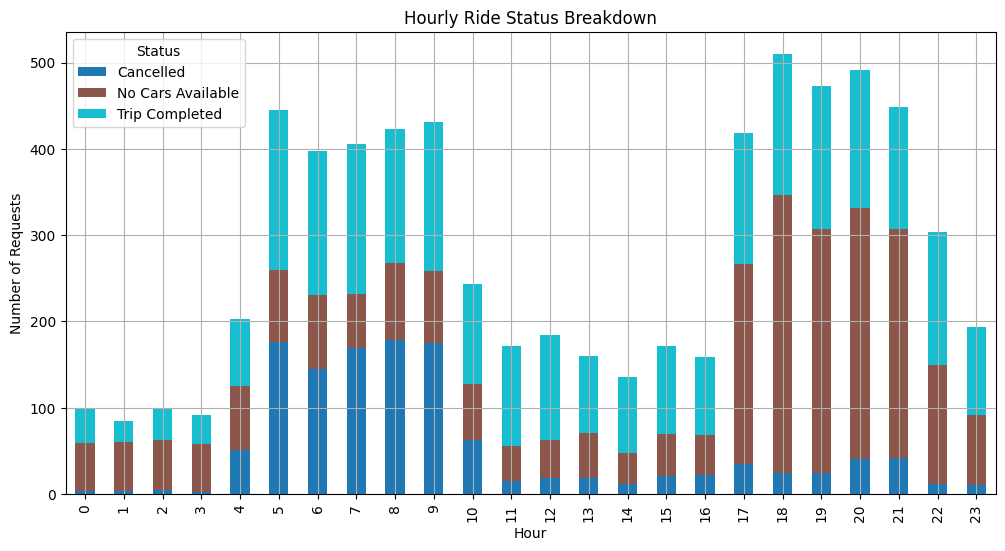

In [ ]:
hourly_status = df.groupby(['Request Hour', 'Status'])['Request id'].count().unstack().fillna(0)
hourly_status.plot(kind='bar', stacked=True, figsize=(12,6), colormap='tab10')
plt.title("Hourly Ride Status Breakdown")
plt.xlabel("Hour")
plt.ylabel("Number of Requests")
plt.legend(title='Status')
plt.grid(True)
plt.show()


8) Trips by Pickup Point (City vs Airport)

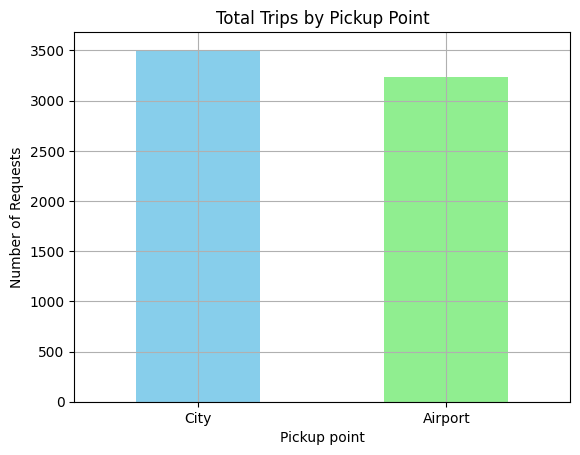

In [ ]:
df['Pickup point'].value_counts().plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.title("Total Trips by Pickup Point")
plt.ylabel("Number of Requests")
plt.xticks(rotation=0)
plt.grid(True)
plt.show()



9) Pie Charts – Status by Pickup Point

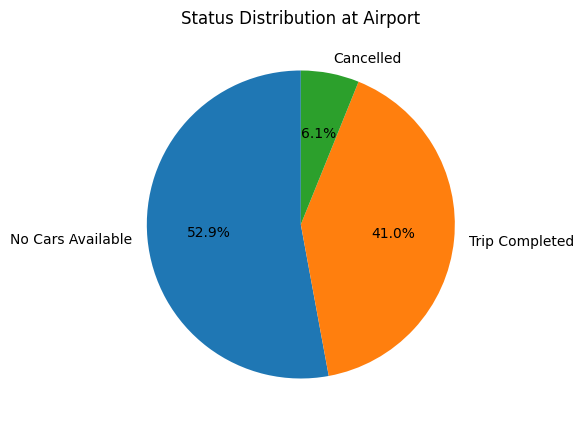

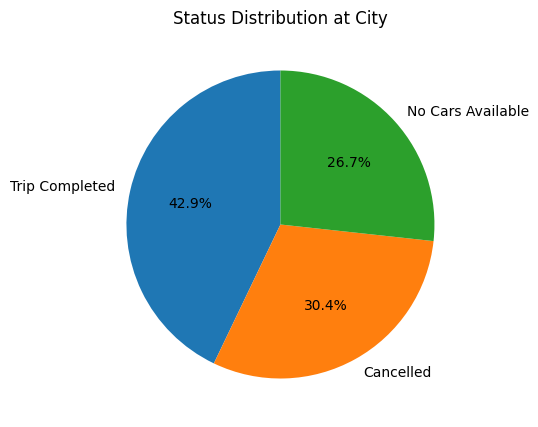

In [ ]:
for location in df['Pickup point'].unique():
    df[df['Pickup point'] == location]['Status'].value_counts().plot.pie(
        autopct='%1.1f%%', startangle=90, figsize=(5,5), title=f'Status Distribution at {location}')
    plt.ylabel("")
    plt.show()


10) Requests by Weekday

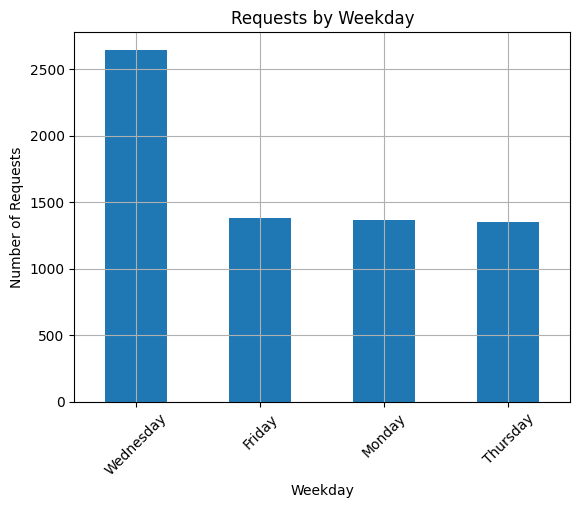

In [ ]:
df['Weekday'] = df['Request timestamp'].dt.day_name()
# Plot the value counts for all available weekdays
df['Weekday'].value_counts().plot(kind='bar')
plt.title("Requests by Weekday")
plt.ylabel("Number of Requests")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

11) Average Duration by Pickup Point

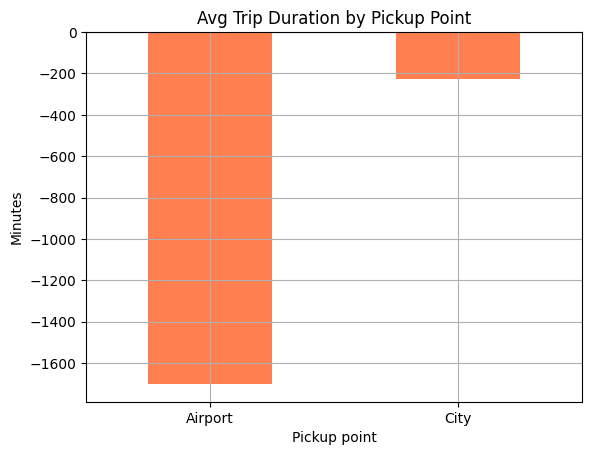

In [ ]:
df[df['Status'] == 'Trip Completed'].groupby('Pickup point')['Trip Duration (min)'].mean().plot(kind='bar', color='coral')
plt.title("Avg Trip Duration by Pickup Point")
plt.ylabel("Minutes")
plt.xticks(rotation=0)
plt.grid(True)
plt.show()


12) Top 10 Drivers by Completed Trips

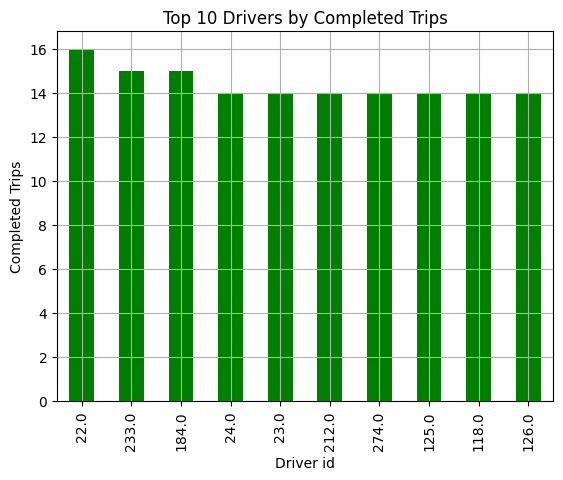

In [ ]:
df[df['Status'] == 'Trip Completed']['Driver id'].value_counts().head(10).plot(kind='bar', color='green')
plt.title("Top 10 Drivers by Completed Trips")
plt.ylabel("Completed Trips")
plt.grid(True)
plt.show()



14) Cancellation Rate per Driver



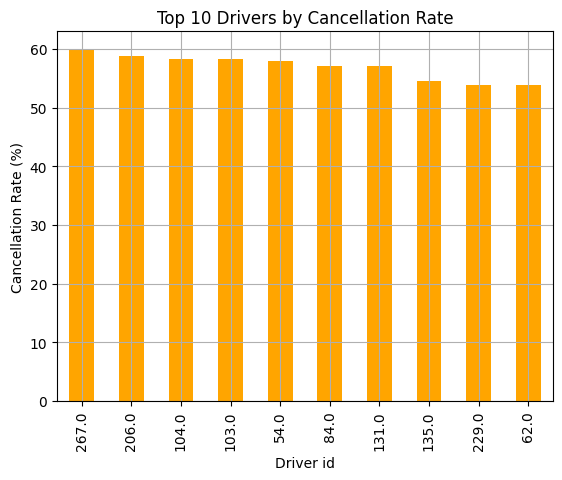

In [ ]:
completed_counts = df[df['Status'] == 'Trip Completed']['Driver id'].value_counts()
cancelled_counts = df[(df['Status'] == 'Cancelled') & (df['Driver id'].notna())]['Driver id'].value_counts()

driver_stats = pd.DataFrame({
    'Completed': completed_counts,
    'Cancelled': cancelled_counts
}).fillna(0)

driver_stats['Cancellation Rate (%)'] = (driver_stats['Cancelled'] / (driver_stats['Completed'] + driver_stats['Cancelled'])) * 100
driver_stats['Cancellation Rate (%)'].sort_values(ascending=False).head(10).plot(kind='bar', color='orange')
plt.title("Top 10 Drivers by Cancellation Rate")
plt.ylabel("Cancellation Rate (%)")
plt.grid(True)
plt.show()


15) Heatmap: Hour vs Pickup Point vs Status

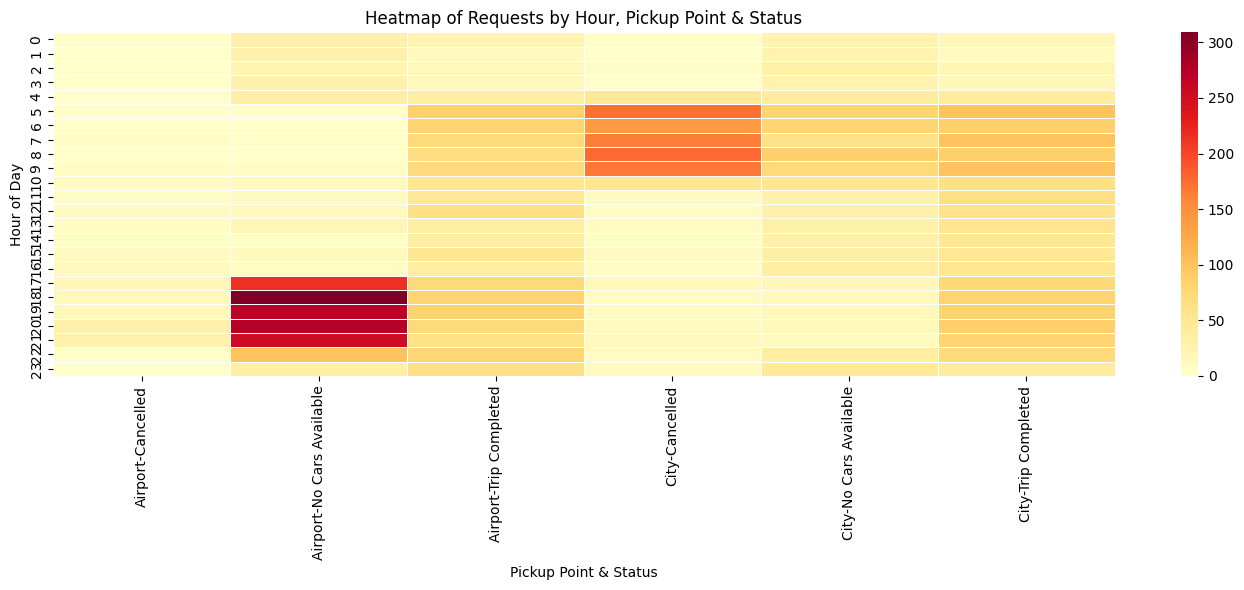

In [ ]:
import seaborn as sns
pivot = df.pivot_table(index='Request Hour', columns=['Pickup point', 'Status'], values='Request id', aggfunc='count', fill_value=0)

plt.figure(figsize=(14,6))
sns.heatmap(pivot, cmap='YlOrRd', annot=False, linewidths=0.5)
plt.title("Heatmap of Requests by Hour, Pickup Point & Status")
plt.xlabel("Pickup Point & Status")
plt.ylabel("Hour of Day")
plt.tight_layout()
plt.show()
